# Customer Segmentation and K-Mean Clustering of Supermarket Store

In this project, we will analyze customer purchasing behavior and segment the supermarket using RFM analysis and basic clustering using k-means. The end-result will provide insights into customer segmentation based on their buying patterns.

**Remarks:** it's essential to note that any conclusions drawn from this project are based on hypothetical data and should not be assumed to reflect the general behavior of all customers.

The dataset used in this analysis was obtained from kaggle.com and includes information on invoices, orders, and sales teams. For the purposes of our analysis, we will mainly focus on the invoice and order data and disregard the sales team data.

If you are interested in accessing the dataset, you can find it at the following link: https://www.kaggle.com/datasets/thedevastator/supermarket-ordering-invoicing-and-sales-analysi?select=OrderLeads.csv

### The required Python modules have been imported, and the corresponding data frame is displayed below.

In [1]:
import pandas as pd
import datetime as dt
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose

invoice = pd.read_csv('Invoices.csv')
leads = pd.read_csv('OrderLeads.csv')

### Datasets preview

In [2]:
invoice.head(5)

,Order Id,Date,Meal Id,Company Id,Date of Meal,Participants,Meal Price,Type of Meal
0,839FKFW2LLX4LMBB,27-05-2016,INBUX904GIHI8YBD,LJKS5NK6788CYMUU,2016-05-31 07:00:00+02:00,['David Bishop'],469,Breakfast
1,97OX39BGVMHODLJM,27-09-2018,J0MMOOPP709DIDIE,LJKS5NK6788CYMUU,2018-10-01 20:00:00+02:00,['David Bishop'],22,Dinner
2,041ORQM5OIHTIU6L,24-08-2014,E4UJLQNCI16UX5CS,LJKS5NK6788CYMUU,2014-08-23 14:00:00+02:00,['Karen Stansell'],314,Lunch
3,YT796QI18WNGZ7ZJ,12-04-2014,C9SDFHF7553BE247,LJKS5NK6788CYMUU,2014-04-07 21:00:00+02:00,['Addie Patino'],438,Dinner
4,6YLROQT27B6HRF4E,28-07-2015,48EQXS6IHYNZDDZ5,LJKS5NK6788CYMUU,2015-07-27 14:00:00+02:00,['Addie Patino' 'Susan Guerrero'],690,Lunch


In [3]:
leads.head(5)

,Order Id,Company Id,Company Name,Date,Order Value,Converted
0,80EYLOKP9E762WKG,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,18-02-2017,4875,1
1,TLEXR1HZWTUTBHPB,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,30-07-2015,8425,0
2,839FKFW2LLX4LMBB,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,27-05-2016,4837,0
3,97OX39BGVMHODLJM,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,27-09-2018,343,0
4,5T4LGH4XGBWOD49Z,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,14-01-2016,983,0


**After reviewing the data description and metadata, it is unclear what type of business the supermarket specifically operates. However, we can infer that the company ID corresponds with the order ID, suggesting that the supermarket may provide wholesale ready meals for businesses such as catering services or restaurants. To proceed with analyzing the data, we will make this assumption.**

Fortunately, upon initial inspection of the dataset, we can see that there are no null values present.

In [4]:
invoice.isna().sum()

Order Id        0
Date            0
Meal Id         0
Company Id      0
Date of Meal    0
Participants    0
Meal Price      0
Type of Meal    0
dtype: int64

Upon inspection of the data types, we can observe that the "date" and "date of meal" columns are not formatted correctly as datetime. Therefore, we need to convert these columns to datetime format to proceed with the next steps of the analysis.

In [5]:
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50017 entries, 0 to 50016
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Order Id      50017 non-null  object
 1   Date          50017 non-null  object
 2   Meal Id       50017 non-null  object
 3   Company Id    50017 non-null  object
 4   Date of Meal  50017 non-null  object
 5   Participants  50017 non-null  object
 6   Meal Price    50017 non-null  int64 
 7   Type of Meal  50017 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.1+ MB


The code lines for converting the "date" and "date of meal" columns to datetime format are displayed below.

In [6]:
invoice['Date'] = pd.to_datetime(invoice['Date'])

In [7]:
invoice['Date of Meal'] = invoice['Date of Meal'].str[:10]
invoice['Date of Meal'] = pd.to_datetime(invoice['Date of Meal'])
invoice['Participants'] = invoice['Participants'].str.replace(r"'\W*?'", "','")
invoice['Participants'] = invoice['Participants'].apply(ast.literal_eval)
invoice['Participants Num'] = invoice['Participants'].apply(lambda x: len(x))

In [8]:
invoice.head(5)

,Order Id,Date,Meal Id,Company Id,Date of Meal,Participants,Meal Price,Type of Meal,Participants Num
0,839FKFW2LLX4LMBB,2016-05-27,INBUX904GIHI8YBD,LJKS5NK6788CYMUU,2016-05-31,[David Bishop],469,Breakfast,1
1,97OX39BGVMHODLJM,2018-09-27,J0MMOOPP709DIDIE,LJKS5NK6788CYMUU,2018-10-01,[David Bishop],22,Dinner,1
2,041ORQM5OIHTIU6L,2014-08-24,E4UJLQNCI16UX5CS,LJKS5NK6788CYMUU,2014-08-23,[Karen Stansell],314,Lunch,1
3,YT796QI18WNGZ7ZJ,2014-12-04,C9SDFHF7553BE247,LJKS5NK6788CYMUU,2014-04-07,[Addie Patino],438,Dinner,1
4,6YLROQT27B6HRF4E,2015-07-28,48EQXS6IHYNZDDZ5,LJKS5NK6788CYMUU,2015-07-27,"[Addie Patino, Susan Guerrero]",690,Lunch,2


In [9]:
leads.head(5)

,Order Id,Company Id,Company Name,Date,Order Value,Converted
0,80EYLOKP9E762WKG,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,18-02-2017,4875,1
1,TLEXR1HZWTUTBHPB,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,30-07-2015,8425,0
2,839FKFW2LLX4LMBB,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,27-05-2016,4837,0
3,97OX39BGVMHODLJM,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,27-09-2018,343,0
4,5T4LGH4XGBWOD49Z,LJKS5NK6788CYMUU,Chimera-Chasing Casbah,14-01-2016,983,0


To obtain a unique buyer ID for your RFM analysis, we could merge the orderleads table with the invoice table. This would allow us to assign the name of the company and the total value of the order from the orderleads data to the corresponding invoice in the invoice table, resulting in a more complete dataset

**The code is shown below:**

In [10]:
invoice_extend = invoice.merge(leads, left_on = ['Order Id','Company Id'], right_on = ['Order Id','Company Id'], how='inner')
invoice_extend = invoice_extend.drop(columns=['Date_y'])
invoice_extend = invoice_extend.rename(columns = {'Date_x':'Date'})

**Preview of out complete dataset**

In [11]:
invoice_extend.head(10)

,Order Id,Date,Meal Id,Company Id,Date of Meal,Participants,Meal Price,Type of Meal,Participants Num,Company Name,Order Value,Converted
0,839FKFW2LLX4LMBB,2016-05-27,INBUX904GIHI8YBD,LJKS5NK6788CYMUU,2016-05-31,[David Bishop],469,Breakfast,1,Chimera-Chasing Casbah,4837,0
1,97OX39BGVMHODLJM,2018-09-27,J0MMOOPP709DIDIE,LJKS5NK6788CYMUU,2018-10-01,[David Bishop],22,Dinner,1,Chimera-Chasing Casbah,343,0
2,041ORQM5OIHTIU6L,2014-08-24,E4UJLQNCI16UX5CS,LJKS5NK6788CYMUU,2014-08-23,[Karen Stansell],314,Lunch,1,Chimera-Chasing Casbah,4185,0
3,YT796QI18WNGZ7ZJ,2014-12-04,C9SDFHF7553BE247,LJKS5NK6788CYMUU,2014-04-07,[Addie Patino],438,Dinner,1,Chimera-Chasing Casbah,5839,0
4,6YLROQT27B6HRF4E,2015-07-28,48EQXS6IHYNZDDZ5,LJKS5NK6788CYMUU,2015-07-27,"[Addie Patino, Susan Guerrero]",690,Lunch,2,Chimera-Chasing Casbah,8841,0
5,AT0R4DFYYAFOC88Q,2014-07-21,W48JPR1UYWJ18NC6,LJKS5NK6788CYMUU,2014-07-17,"[David Bishop, Susan Guerrero, Karen Stansell]",181,Dinner,3,Chimera-Chasing Casbah,1883,0
6,2DDN2LHS7G85GKPQ,2014-04-29,1MKLAKBOE3SP7YUL,LJKS5NK6788CYMUU,2014-04-30,"[Susan Guerrero, David Bishop]",14,Dinner,2,Chimera-Chasing Casbah,202,0
7,FM608JK1N01BPUQN,2014-08-05,E8WJZ1FOSKZD2MJN,36MFTZOYMTAJP1RK,2014-05-07,"[Amanda Knowles, Cheryl Feaster, Ginger Hoagla...",320,Breakfast,4,Tangential Sheds,3762,1
8,CK331XXNIBQT81QL,2015-05-23,CTZSFFKQTY7SBZ4J,36MFTZOYMTAJP1RK,2015-05-18,"[Cheryl Feaster, Amanda Knowles, Ginger Hoagland]",697,Lunch,3,Tangential Sheds,7746,0
9,FESGKOQN2OZZWXY3,2016-10-01,US0NQYNNHS1SQJ4S,36MFTZOYMTAJP1RK,2016-01-14,"[Glenn Gould, Amanda Knowles, Ginger Hoagland,...",451,Dinner,4,Tangential Sheds,6011,1


### Exploratory Data Analysis (EDA)

**After our initial data preprocessing, our resulting table is shown below.**

In [12]:
#unstack_invoice =  unstack_invoice[unstack_invoice['Type of Meal'] == 'Breakfast']

In [13]:
invoice_extend

,Order Id,Date,Meal Id,Company Id,Date of Meal,Participants,Meal Price,Type of Meal,Participants Num,Company Name,Order Value,Converted
0,839FKFW2LLX4LMBB,2016-05-27,INBUX904GIHI8YBD,LJKS5NK6788CYMUU,2016-05-31,[David Bishop],469,Breakfast,1,Chimera-Chasing Casbah,4837,0
1,97OX39BGVMHODLJM,2018-09-27,J0MMOOPP709DIDIE,LJKS5NK6788CYMUU,2018-10-01,[David Bishop],22,Dinner,1,Chimera-Chasing Casbah,343,0
2,041ORQM5OIHTIU6L,2014-08-24,E4UJLQNCI16UX5CS,LJKS5NK6788CYMUU,2014-08-23,[Karen Stansell],314,Lunch,1,Chimera-Chasing Casbah,4185,0
3,YT796QI18WNGZ7ZJ,2014-12-04,C9SDFHF7553BE247,LJKS5NK6788CYMUU,2014-04-07,[Addie Patino],438,Dinner,1,Chimera-Chasing Casbah,5839,0
4,6YLROQT27B6HRF4E,2015-07-28,48EQXS6IHYNZDDZ5,LJKS5NK6788CYMUU,2015-07-27,"[Addie Patino, Susan Guerrero]",690,Lunch,2,Chimera-Chasing Casbah,8841,0
...,...,...,...,...,...,...,...,...,...,...,...,...
50012,4OMS8ZSA0UX8LHWI,2017-09-20,1TD5MROATV1NHZ4Y,E4K99D4JR9E40VE1,2017-09-21,[Regina Shirley],9,Breakfast,1,Fierce Productivity,110,0
50013,RR0VKJN8V0KHNKGG,2018-03-19,22EX9VZSJKHP4AIP,E4K99D4JR9E40VE1,2018-03-18,"[Robin Ramos, Chester Mortimer]",25,Breakfast,2,Fierce Productivity,356,0
50014,STJ6QJC30WPRM93H,2017-09-21,LMX18PNGWCIMG1QW,E4K99D4JR9E40VE1,2017-09-22,[Robin Ramos],160,Dinner,1,Fierce Productivity,2228,1
50015,QHEUIYNC0XQX7GDR,2018-01-28,4U0VH2TGQL30X23X,E4K99D4JR9E40VE1,2018-02-01,"[Chester Mortimer, Robin Ramos]",497,Dinner,2,Fierce Productivity,8869,0


Next let's perform some EDA on the data to see what kind of insight we can get from the data 

In [14]:
eda = invoice_extend.copy()

### Counting Clients and Order Made

In [15]:
print(f"There are {eda['Company Id'].nunique()} unique clients")
print(f"There are {eda['Order Id'].nunique()} Orders")

There are 4725 unique clients
There are 50017 Orders


### Order Values by Day of Week

In [16]:
eda['dow'] = eda['Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

<AxesSubplot: xlabel='dow', ylabel='Ordervalue'>

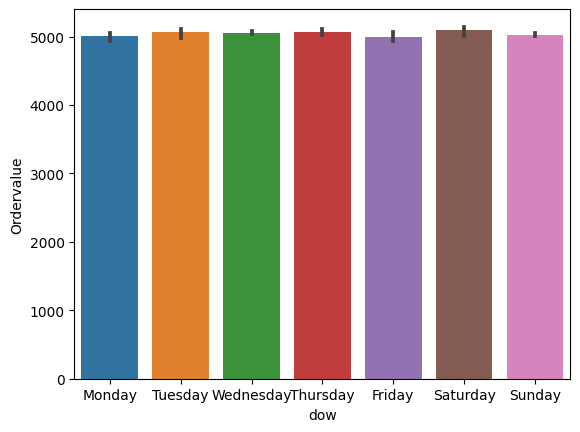

In [17]:
sns.barplot(x='dow', y='Ordervalue', data=eda.groupby(['dow', 'Type of Meal']).agg(Ordervalue = ('Order Value', 'mean')).reset_index(), order=day_order)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=7)

**Implication**
- The average order value is similar across all days of the week

### Sales Conversion

Text(0, 0.5, 'Order Count')

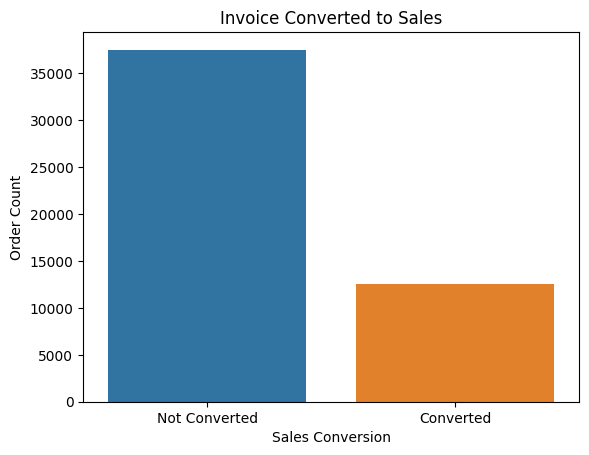

In [18]:
sns.countplot(x='Converted', data=eda)
plt.title('Invoice Converted to Sales')
plt.xticks(ticks=[0,1], labels=["Not Converted", "Converted"])
plt.xlabel('Sales Conversion')
plt.ylabel('Order Count')

In [19]:
conversionrate = eda[eda['Converted']==1]['Order Id'].nunique() / eda['Order Id'].nunique()
print(conversionrate * 100)

25.021492692484554


**Implications**
- Many of the invoices still has not been converted to sales, businesses may experience a low conversion rate with only about 25%, which means that only a small percentage of leads or prospects eventually become paying customers.

Text(0.5, 1.0, 'Invoices by Meal')

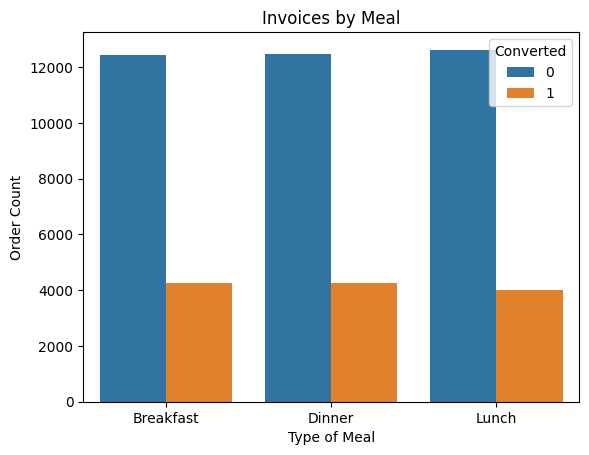

In [20]:
sns.countplot(x='Type of Meal', data=eda, hue='Converted')
plt.ylabel('Order Count')
plt.title('Invoices by Meal')

**Implication**
- The number of orders placed for each type of meal appears to be relatively similar, and the conversion rate for each meal type is also comparable.
- There is no clear evidence to suggest that customers in this supermarket significantly prefer one type of meal over another

In [21]:
grouped = eda.groupby('Date').agg(TotalOrder = ('Order Id','nunique'))

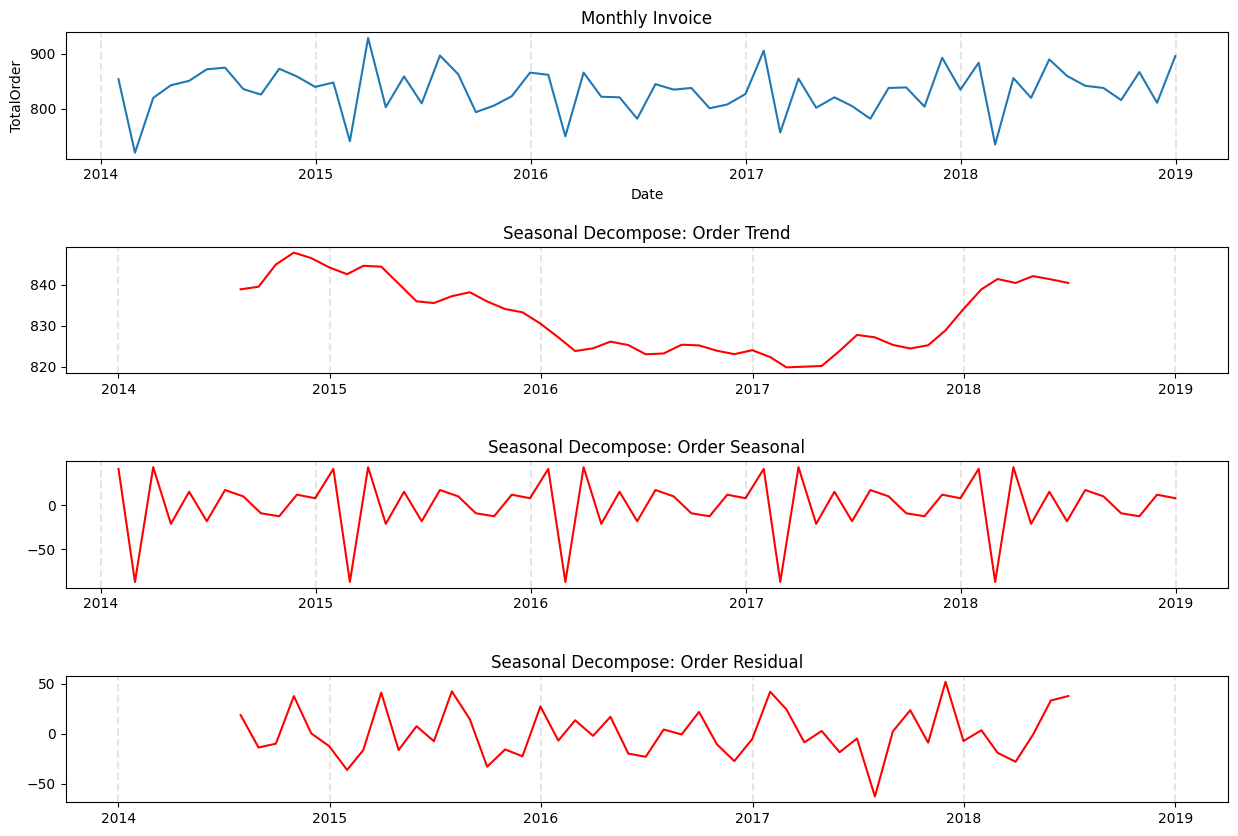

In [22]:
decomp = seasonal_decompose(grouped.resample('M').sum(), model='additive')

def year_line():
    for year in range(2014,2020):
        plt.axvline(dt.datetime(year,1,1), color='k', linestyle='--', alpha=0.1)
        
plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
sns.lineplot(x='Date', y='TotalOrder', data=grouped.resample('M').sum())
plt.title('Monthly Invoice')
year_line()

plt.subplot(4,1,2)
plt.plot(decomp.trend, color='red')
plt.title('Seasonal Decompose: Order Trend')
year_line()

plt.subplot(4,1,3)
plt.plot(decomp.seasonal, color='red')
plt.title('Seasonal Decompose: Order Seasonal')
year_line()

plt.subplot(4,1,4)
plt.plot(decomp.resid, color='red')
plt.title('Seasonal Decompose: Order Residual')
year_line()

plt.subplots_adjust(hspace=0.7)


**Implications**
- The trend in order amounts appears to have slightly decreased from 2014 to 2017, and then began to increase around mid-2017.
- Examining the seasonality of orders, there is a clear drop in order amounts during the beginning of the year, while the order amounts seem to hold steady during other periods of the year.

In [23]:
eda

,Order Id,Date,Meal Id,Company Id,Date of Meal,Participants,Meal Price,Type of Meal,Participants Num,Company Name,Order Value,Converted,dow
0,839FKFW2LLX4LMBB,2016-05-27,INBUX904GIHI8YBD,LJKS5NK6788CYMUU,2016-05-31,[David Bishop],469,Breakfast,1,Chimera-Chasing Casbah,4837,0,Friday
1,97OX39BGVMHODLJM,2018-09-27,J0MMOOPP709DIDIE,LJKS5NK6788CYMUU,2018-10-01,[David Bishop],22,Dinner,1,Chimera-Chasing Casbah,343,0,Thursday
2,041ORQM5OIHTIU6L,2014-08-24,E4UJLQNCI16UX5CS,LJKS5NK6788CYMUU,2014-08-23,[Karen Stansell],314,Lunch,1,Chimera-Chasing Casbah,4185,0,Sunday
3,YT796QI18WNGZ7ZJ,2014-12-04,C9SDFHF7553BE247,LJKS5NK6788CYMUU,2014-04-07,[Addie Patino],438,Dinner,1,Chimera-Chasing Casbah,5839,0,Thursday
4,6YLROQT27B6HRF4E,2015-07-28,48EQXS6IHYNZDDZ5,LJKS5NK6788CYMUU,2015-07-27,"[Addie Patino, Susan Guerrero]",690,Lunch,2,Chimera-Chasing Casbah,8841,0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50012,4OMS8ZSA0UX8LHWI,2017-09-20,1TD5MROATV1NHZ4Y,E4K99D4JR9E40VE1,2017-09-21,[Regina Shirley],9,Breakfast,1,Fierce Productivity,110,0,Wednesday
50013,RR0VKJN8V0KHNKGG,2018-03-19,22EX9VZSJKHP4AIP,E4K99D4JR9E40VE1,2018-03-18,"[Robin Ramos, Chester Mortimer]",25,Breakfast,2,Fierce Productivity,356,0,Monday
50014,STJ6QJC30WPRM93H,2017-09-21,LMX18PNGWCIMG1QW,E4K99D4JR9E40VE1,2017-09-22,[Robin Ramos],160,Dinner,1,Fierce Productivity,2228,1,Thursday
50015,QHEUIYNC0XQX7GDR,2018-01-28,4U0VH2TGQL30X23X,E4K99D4JR9E40VE1,2018-02-01,"[Chester Mortimer, Robin Ramos]",497,Dinner,2,Fierce Productivity,8869,0,Sunday


### Customer Segmentation: Premises of the analysis

**The scope of this analysis is that:**

We will be performing customer segmentation based on their purchasing behavior using the RFM(and T) (Recency, Frequency, Monetary, Tenure) analysis method along with basic clustering using KMeans. This will help us identify different groups of customers and understand their behaviors, preferences and potential value to the business.

We will be focusing on customer behavior, regardless of whether an invoice has been converted to a sale or not. This means that we will consider customers who have placed an invoice but not yet converted, as well as customers who have already made a purchase. By analyzing the behavior of both groups, we can gain insights into their preferences, needs, and buying habits

### RFM Analysis

**RFM analysis** is a customer segmentation technique that helps businesses identify and target their most valuable customers. RFM stands for Recency, Frequency, and Monetary Value. 
- **Recency** refers to how recently a customer has made a purchase
- **Frequency refers** to how often a customer makes purchases
- **Monetary Value** refers to how much a customer spends on each purchase.
- **(Additonal Metric) Tenure** how customer have been conducting business with us

***All time based variables are measures in days**

By analyzing these three variables, businesses can group their customers into segments based on their buying behavior. This information can then be used to develop targeted marketing strategies and improve customer engagement. 

**For example,** businesses can identify their most valuable customers like for instance those with high monetary value and frequent purchases) and tailor their marketing efforts to retain and upsell them.

Since the dataset is quite old, it may be necessary to adjust the analysis to account for changes in customer behavior over time. One approach could be to pretend to **start the analysis after the last date of invoice**, which would provide a more accurate representation of time based metrics

**The codelines for RFM(T) are displayed below**

In [24]:
snapshotdate = invoice_extend['Date'].max() + dt.timedelta(days=1)

rfm = invoice_extend.groupby(['Company Id']).agg(Recency = ('Date', lambda x: (snapshotdate - x.max()).days), Frequency = ('Order Id', 'count'), MonataryValue = ('Order Value', 'sum'), Tenure = ('Date', lambda x: (snapshotdate - x.min()).days))
rfm = rfm.reset_index()
rfm

,Company Id,Recency,Frequency,MonataryValue,Tenure
0,007RF0BCBVMXTL80,95,10,51386,1553
1,00CVEIVO8C92FFBO,144,14,70267,1449
2,00OFNRZV8983KC3L,431,7,49035,1671
3,00R1H0DBLAVXHOTZ,114,9,59883,1430
4,00WJ866YXWT58K2S,206,14,65112,1620
...,...,...,...,...,...
4720,ZZ2R72YGH1JQH2OB,140,9,56736,1503
4721,ZZ99YI36NDHV7ELT,33,12,79368,1647
4722,ZZD813K8WK65MND6,274,5,15397,1513
4723,ZZY3WSHGJWPKJBCV,223,17,85201,1725


To segment customers based on their RFM scores, we can divide each variable (Recency, Frequency, and Monetary Value) into four groups based on their value. This can be done using pandas qcut function, which assigns values to quantiles.

After using the pandas qcut function to divide each variable (Recency, Frequency, and Monetary Value) into four groups based on their value, we can assign RFM scores to each customer based on their quartile rankings for each variable.

To do this, we can add 3 new columns to the dataset
- **Total RFM score**, the sum of the quartile rankings for all three variables)
- **The RFM segment**, a concatenated text of the quartile rankings for each variable in respective order).
- **Custom ranking**, a custom assignment of rankings based on the Total RFM score

**The codelines are displayed below**

In [25]:
r_labels = range(4,0,-1) #less is better
f_labels = range(1,5) #more is better
m_labels = range(1,5) #more is better
t_labels = range(1,5) #more is better

rfm['R_NumberRanks'] = rfm['Recency'].rank(method='first')
rfm['R'] = rfm['R_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = r_labels))

rfm['F_NumberRanks'] = rfm['Frequency'].rank(method='first')
rfm['F'] = rfm['F_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = f_labels))

rfm['M_NumberRanks'] = rfm['MonataryValue'].rank(method='first')
rfm['M'] = rfm['M_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = m_labels))

rfm['T_NumberRanks'] = rfm['Tenure'].rank(method='first')
rfm['T'] = rfm['T_NumberRanks'].transform(lambda x: pd.qcut(x.rank(method='first'), q = 4, labels = t_labels))

In [26]:
def get_segment(data):
    if data['rfmscore'] <= 4:
        return 'tier 4'
    elif data['rfmscore'] <= 8:
        return 'tier 3'
    elif data['rfmscore'] <= 12:
        return 'tier 2'
    else:
        return 'tier 1'

In [27]:
rfm['rfmscore'] = rfm[['R','F','M','T']].sum(axis=1)
rfm['R'] = rfm['R'].astype(str)
rfm['F'] = rfm['F'].astype(str)
rfm['M'] = rfm['M'].astype(str)
rfm['T'] = rfm['T'].astype(str)
rfm['segment'] = rfm.apply(lambda x: str(x['R']) +  str(x['F']) +  str(x['M']) +  str(x['T']), axis=1)
rfm['tier'] = rfm.apply(get_segment, axis=1)
rfm = rfm.drop(columns=['R_NumberRanks','F_NumberRanks','M_NumberRanks','T_NumberRanks'])

In [28]:
rfm.head(10)

,Company Id,Recency,Frequency,MonataryValue,Tenure,R,F,M,T,rfmscore,segment,tier
0,007RF0BCBVMXTL80,95,10,51386,1553,3,2,2,1,8,3221,tier 3
1,00CVEIVO8C92FFBO,144,14,70267,1449,2,4,4,1,11,2441,tier 2
2,00OFNRZV8983KC3L,431,7,49035,1671,1,1,2,2,6,1122,tier 3
3,00R1H0DBLAVXHOTZ,114,9,59883,1430,3,2,3,1,9,3231,tier 2
4,00WJ866YXWT58K2S,206,14,65112,1620,2,4,3,2,11,2432,tier 2
5,0137AG0TZT4IC8ZT,141,12,53804,1772,2,3,3,3,11,2333,tier 2
6,01EY1XGH4Z0K7EH0,234,15,72316,1728,1,4,4,3,12,1443,tier 2
7,01W2DWJSSYIMC2CP,290,7,47324,1555,1,1,2,1,5,1121,tier 3
8,0215YHE3CHAJKSYO,340,9,17429,1756,1,2,1,3,7,1213,tier 3
9,025D9V9W1WIYQB0H,199,11,61934,1660,2,3,3,2,10,2332,tier 2


To gain a better understanding of customer rankings, we can calculate the average value for each variable in each quartile tier. This will provide us with a broader view of how customers are distributed across the different segments.

By looking at the average values for each tier, we can identify distinct customer segments within each quartile. These segments can be targeted with specific marketing strategies based on their buying patterns.

In [29]:
rfm.groupby('tier').agg(Recency=('Recency','mean'), 
                        Frequency=('Frequency', 'mean'), 
                        Monatary=('MonataryValue','mean'), 
                        TransactionCount = ('Recency','count'),
                        Tenure=('Tenure','mean'),
                        ClientCount=('Tenure','count'))

,Recency,Frequency,Monatary,TransactionCount,Tenure,ClientCount
tier,,,,,,
tier 1,70.529778,14.090667,73525.454222,1125,1751.369778,1125
tier 2,146.120159,10.981629,55399.964747,2014,1677.389275,2014
tier 3,240.194969,7.788260,37518.023061,1431,1580.549965,1431
tier 4,440.735484,5.825806,27807.670968,155,1373.819355,155


**Implications**
- we can see that tier 1 clients have a low recency (i.e., they have made a purchase recently), a high order frequency, and a high monetary value. As we move down the list of tiers, each variable worsens.
- In our specific case, we observe that the supermarket has a larger number of tier 2 clients than any other tier. This means that the majority of our customers have medium recency, frequency, and monetary value.

However, it is important to note that the RFM analysis has its limitations. The analysis only segments customers based on the overall picture of each variable.

There may be a customer segments that we might miss. For instance, customers who have a high recency but have made a large, substantial purchase may not be detected by the RFM analysis. This could result in these customers being lumped in with lower-value customers, and not being targeted with appropriate marketing strategies.

To address the limitations of the RFM analysis, we can complement it with other analytical tools such as **K-Means clustering**

### K-Means Clustering

K-Means clustering is an unsupervised machine learning algorithm that can help us identify hidden patterns and segments within our customer base.

### Data preprocessing for K-Means Clustering

It's important that for a data to use K-mean clustering its variable must have a normal distribution and no skewness. let's plot the distribution of our RFM(T) table to see if the each variablk has a normal distrbutin  

<AxesSubplot: xlabel='Tenure', ylabel='Density'>

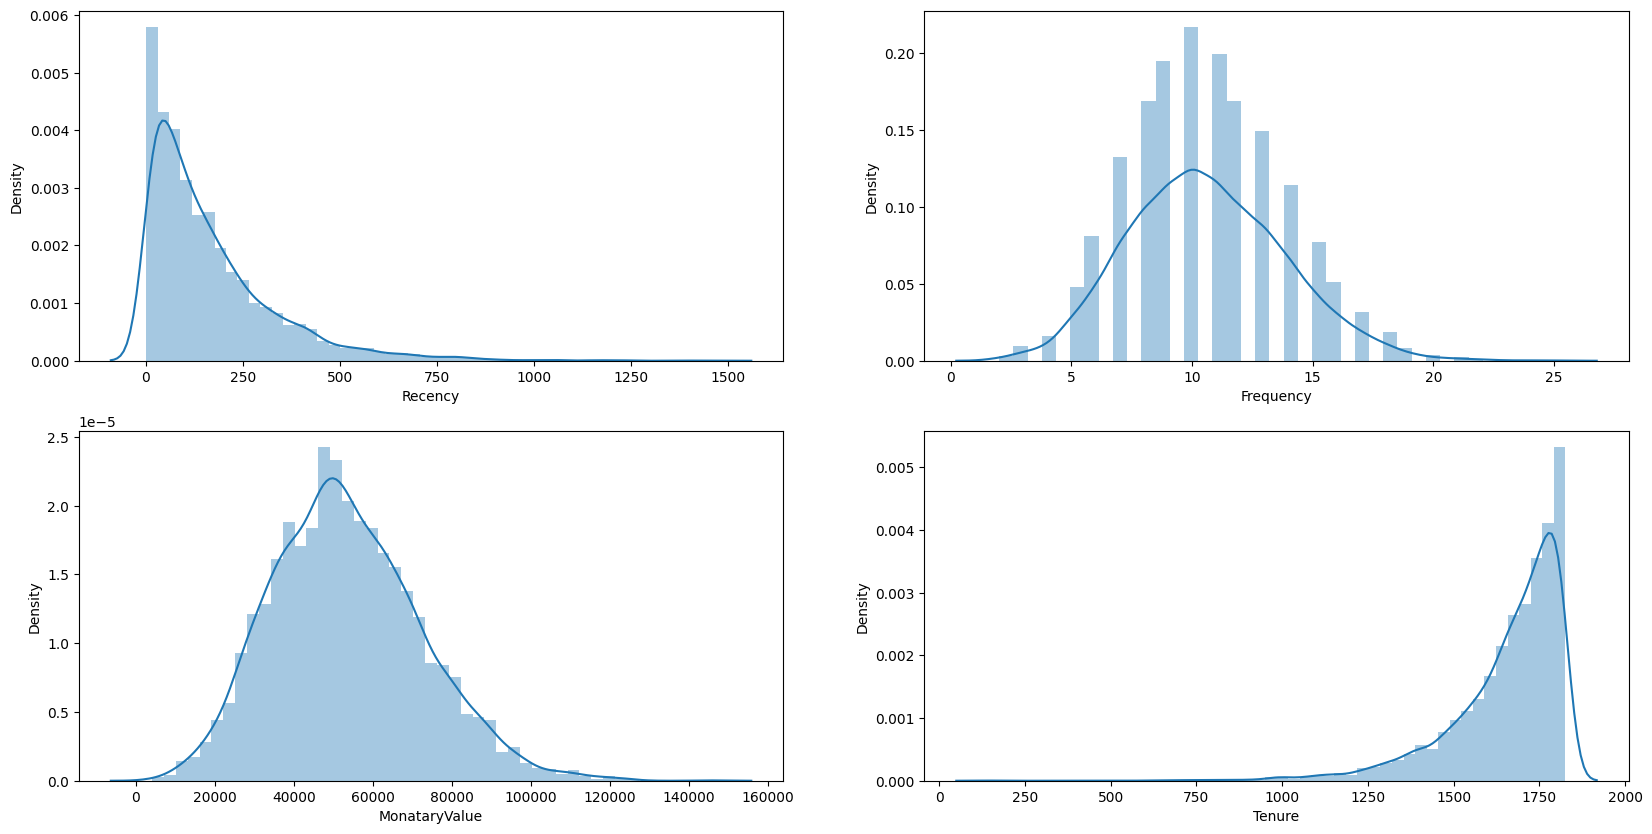

In [30]:
#distribution of recency, frequency, monatary
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.distplot(rfm['Recency'])

plt.subplot(2,2,2)
sns.distplot(rfm['Frequency'])

plt.subplot(2,2,3)
sns.distplot(rfm['MonataryValue'])

plt.subplot(2,2,4)
sns.distplot(rfm['Tenure'])

We observed that the Recency variable is heavily skewed to the right, while the Tenure variable is heavily skewed to the left. On the other hand, the Frequency and Monetary Value variables have a normal distribution.

To address the skewness in the data, we can apply a **log transformation** to the Recency and Frequency variables. This will compress the range of values and reduce the influence of outliers, resulting in a more normally distributed data.

**The code line for applying log transformation to the Recency and Frequency variables can be displayed below:**

<AxesSubplot: xlabel='Tenure', ylabel='Density'>

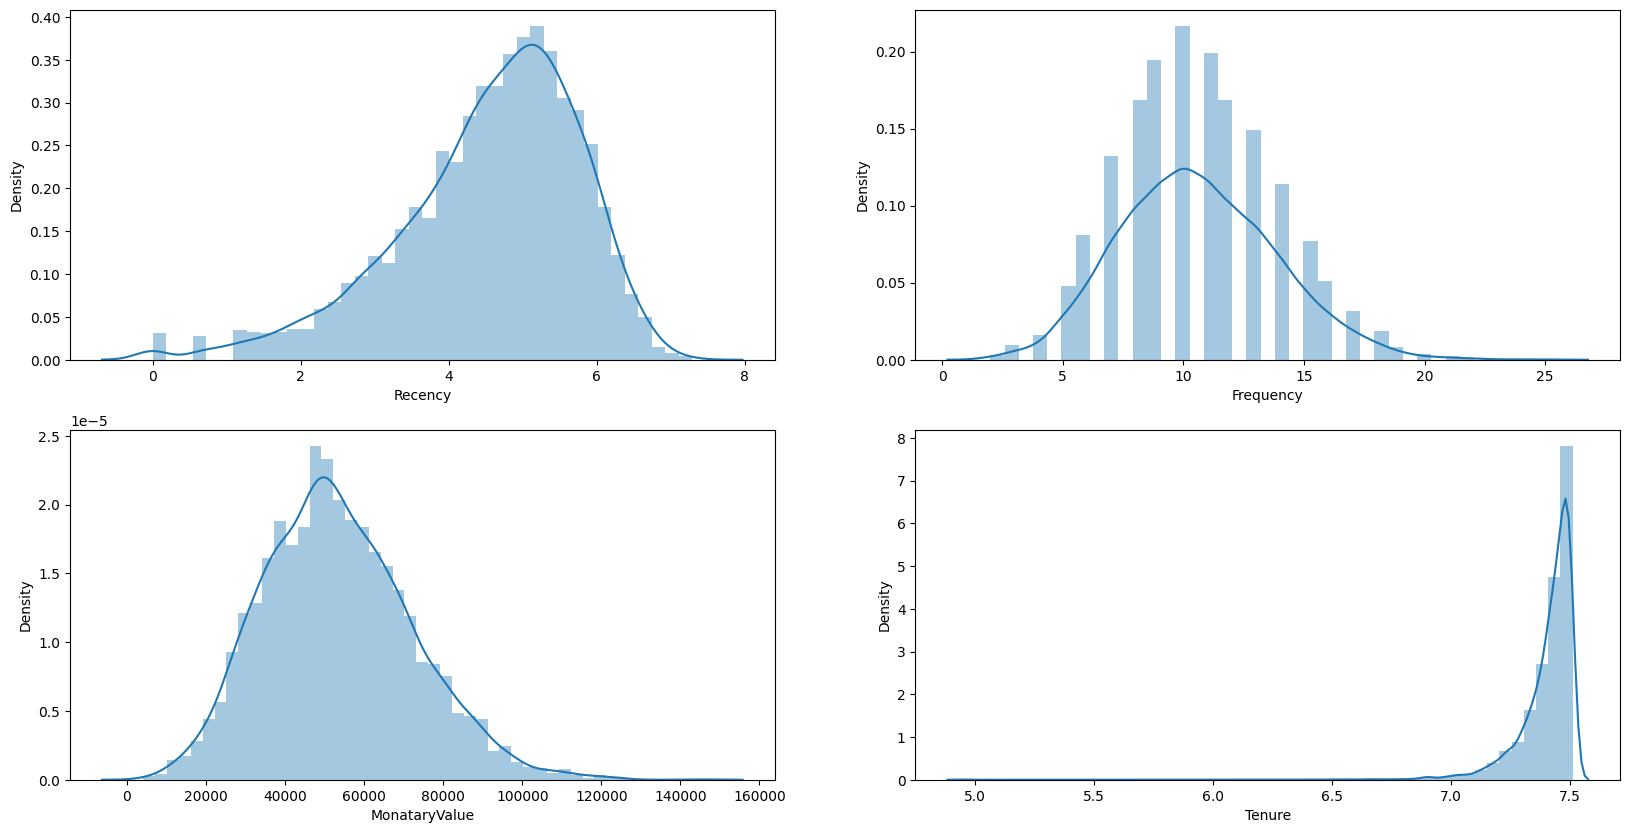

In [31]:
#unskewing data

r_log = np.log(rfm['Recency'])
#f_log = np.log(rfm['Frequency'])
#m_log = np.log(rfm['MonataryValue'])
t_log = np.log(rfm['Tenure'])

rfm['rlog'] = r_log 
#rfm['flog'] = f_log 
#rfm['mlog'] = m_log 
rfm['tlog'] = t_log 

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.distplot(r_log)

plt.subplot(2,2,2)
sns.distplot(rfm['Frequency'])

plt.subplot(2,2,3)
sns.distplot(rfm['MonataryValue'])

plt.subplot(2,2,4)
sns.distplot(t_log)


After applying log transformation to the Recency and Tenure variables, we can observe that their distributions are closer to normal compared to the pre-log transformation. 

Although the **Tenure variable still has some left skewness**, the tail is much shorter than the pre-log transformation. This suggests that the log transformation has reduced the influence of extreme values and made the data more suitable for further analysis.

### Standardizing variables

Once we have confirmed that all variables are normally distributed, we can standardize the values using StandardScaler(). This involves converting the values to standardized scores by subtracting the variable mean and dividing by its standard deviation. This standardization step is necessary for K-means clustering as it ensures that each variable is given equal importance during clustering.

In [32]:
#center/scaling the data wither manual or StandardScaler
kmean_rfm = rfm[['rlog', 'Frequency', 'MonataryValue', 'tlog']]
scale = StandardScaler()
scale.fit(kmean_rfm)
rfm_normalized = scale.transform(kmean_rfm)
#rfm_censcale = (kmean_rfm - kmean_rfm.mean()) / kmean_rfm.std()

**The result table containing the standardized score is shown below**

In [33]:
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized = rfm_normalized.rename(columns={0:'Recency', 1:'Frequency', 2:'MonataryValue', 3:'Tenure'})
#in recency less means better 
rfm_normalized['Recency']  = rfm_normalized['Recency'] * -1
rfm_normalized

,Recency,Frequency,MonataryValue,Tenure
0,-0.000661,-0.182235,-0.106425,-0.492052
1,-0.337639,1.062520,0.893905,-1.080570
2,-1.225821,-1.115801,-0.230982,0.129739
3,-0.148371,-0.493423,0.343753,-1.192638
4,-0.627729,1.062520,0.620789,-0.133434
...,...,...,...,...
4720,-0.314815,-0.493423,0.177022,-0.769908
4721,0.855985,0.440143,1.376083,0.006908
4722,-0.858831,-1.738178,-2.013149,-0.713604
4723,-0.691972,1.996086,1.685120,0.399777


### Define number of clusters using elbow criterion

Next, we will determine the optimal number of clusters for our analysis. While the number can be chosen freely, we will use the "Elbow Criterion" to determine the number of clusters. 

_"The Elbow Criterion works by plotting the sum of squared distances between each point and its assigned cluster center (inertia) against the number of clusters. The optimal number of clusters is typically the "elbow point" on the plot, where additional clusters no longer significantly reduce the inertia."_

In [34]:
#define number of clusters using elbow criterion
sse = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

<AxesSubplot: >

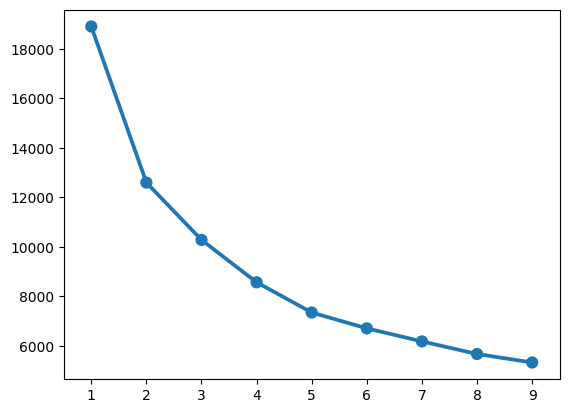

In [35]:
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

It seem 3 cluster is approprite numbers but bare in mind that this number is not a definite one, increasing more cluster may helpo use to discover hidden segment that might be useful for out business stratfy

It appears that 3 clusters are appropriate for our data based on the Elbow Criterion, **but it is important to keep in mind that this number is not fixed**. Increasing the number of clusters may help us discover hidden segments that could be useful for our business strategy.

in this case we will be taking 4 clusters for precautions

### After determining the appropriate number of clusters, we will fit the K-means model to our data.

In [36]:
rfm_kmeans = KMeans(n_clusters=6, random_state=1)
rfm_kmeans.fit(rfm_normalized)
cluster_labels = rfm_kmeans.labels_

In [37]:
rfm = rfm.assign(cluster = cluster_labels)
rfm

,Company Id,Recency,Frequency,MonataryValue,Tenure,R,F,M,T,rfmscore,segment,tier,rlog,tlog,cluster
0,007RF0BCBVMXTL80,95,10,51386,1553,3,2,2,1,8,3221,tier 3,4.553877,7.347944,3
1,00CVEIVO8C92FFBO,144,14,70267,1449,2,4,4,1,11,2441,tier 2,4.969813,7.278629,3
2,00OFNRZV8983KC3L,431,7,49035,1671,1,1,2,2,6,1122,tier 3,6.066108,7.421178,5
3,00R1H0DBLAVXHOTZ,114,9,59883,1430,3,2,3,1,9,3231,tier 2,4.736198,7.265430,3
4,00WJ866YXWT58K2S,206,14,65112,1620,2,4,3,2,11,2432,tier 2,5.327876,7.390181,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4720,ZZ2R72YGH1JQH2OB,140,9,56736,1503,2,2,3,1,8,2231,tier 3,4.941642,7.315218,3
4721,ZZ99YI36NDHV7ELT,33,12,79368,1647,4,3,4,2,13,4342,tier 1,3.496508,7.406711,0
4722,ZZD813K8WK65MND6,274,5,15397,1513,1,1,1,1,4,1111,tier 4,5.613128,7.321850,5
4723,ZZY3WSHGJWPKJBCV,223,17,85201,1725,2,4,4,3,13,2443,tier 1,5.407172,7.452982,2


After assigning a cluster to each of our clients, we will group them to see the general trend of the RFMT variables in each cluster.

In [38]:
cluster_mean = rfm.groupby('cluster').agg(Recency=('Recency','mean'), Frequency=('Frequency', 'mean'), Monatary=('MonataryValue','mean'), Tenure = ('Tenure', 'mean'), TransactionCount = ('Recency','count')).round(2)
cluster_mean = cluster_mean.reset_index()
cluster_mean

,cluster,Recency,Frequency,Monatary,Tenure,TransactionCount
0,0,16.31,12.74,64880.80,1695.45,541
1,1,46.84,8.67,41107.10,1660.26,704
2,2,117.54,15.54,83262.30,1715.98,644
3,3,191.90,11.47,58264.59,1700.88,1438
4,4,180.76,7.61,38312.16,1237.00,353
5,5,314.27,7.49,35713.53,1674.24,1045


### Visualizing Clusters

In case that tabular result might be too difficult to read, we can also visualize it by make use of one of the many useful visualizing tool like **snake plot.**

A snake plot is a way to visualize the average values of each RFM variable across different clusters. It shows a line plot of the average values for each variable in each cluster, with the lines connecting the values for each variable for a given cluster. 

This can help us to easily compare the clusters and see which variables are driving the differences between them.

In [39]:
#snake plot
snake_rfm_normalized = rfm_normalized.copy()
snake_rfm_normalized['cluster'] = rfm['cluster']
snake_rfm_normalized['Company Id'] = rfm['Company Id']
snake_rfm_normalized_melt = pd.melt(snake_rfm_normalized, id_vars=['Company Id', 'cluster'], value_vars=['Recency', 'Frequency', 'MonataryValue', 'Tenure'], var_name='attribute', value_name='value')

In [40]:
snake_rfm_normalized_melt

,Company Id,cluster,attribute,value
0,007RF0BCBVMXTL80,3,Recency,-0.000661
1,00CVEIVO8C92FFBO,3,Recency,-0.337639
2,00OFNRZV8983KC3L,5,Recency,-1.225821
3,00R1H0DBLAVXHOTZ,3,Recency,-0.148371
4,00WJ866YXWT58K2S,3,Recency,-0.627729
...,...,...,...,...
18895,ZZ2R72YGH1JQH2OB,3,Tenure,-0.769908
18896,ZZ99YI36NDHV7ELT,0,Tenure,0.006908
18897,ZZD813K8WK65MND6,5,Tenure,-0.713604
18898,ZZY3WSHGJWPKJBCV,2,Tenure,0.399777


(-4.0, 4.0)

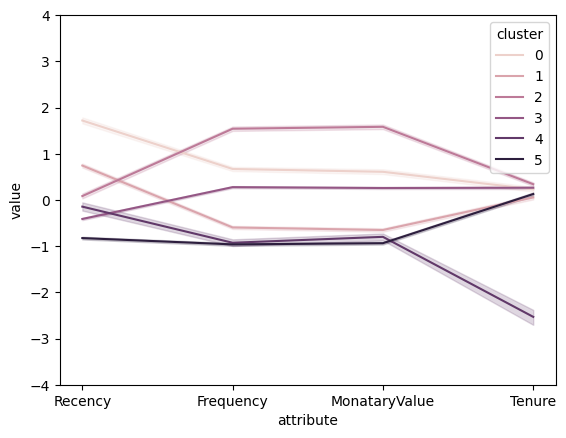

In [41]:
sns.lineplot(x='attribute', y='value', hue='cluster', data=snake_rfm_normalized_melt)
plt.ylim(-4,4)

### Relative Importance Heatmap

In [42]:
cluster_average = rfm[['Recency', 'Frequency', 'MonataryValue', 'Tenure', 'cluster']].groupby('cluster').mean()
population_average = rfm[['Recency', 'Frequency', 'MonataryValue', 'Tenure']].mean()
relative_implication = cluster_average / population_average - 1

In [43]:
relative_implication.round(4)

,Recency,Frequency,MonataryValue,Tenure
cluster,,,,
0,-0.9019,0.2033,0.2151,0.0240
1,-0.7183,-0.1809,-0.2301,0.0027
2,-0.2931,0.4678,0.5594,0.0364
3,0.1541,0.0840,0.0912,0.0273
4,0.0871,-0.2815,-0.2825,-0.2529
5,0.8900,-0.2922,-0.3311,0.0112


Text(0.5, 1.0, 'Relative importance of RFMT attributes')

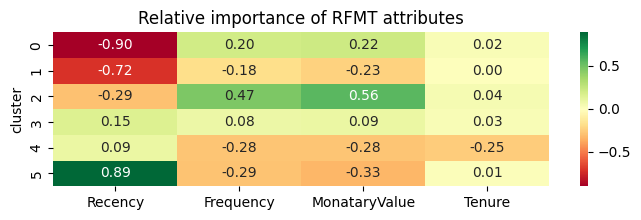

In [44]:
plt.figure(figsize=(8, 2))
sns.heatmap(data=relative_implication, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Relative importance of RFMT attributes')

### Bare in mind that less recency means better so in this case negative value in recency means that client have recently placed an order

### Interpreting the clusters

Now that we have both tabular and visual result let analyze the customer segmentation

In [45]:
cluster_mean

,cluster,Recency,Frequency,Monatary,Tenure,TransactionCount
0,0,16.31,12.74,64880.80,1695.45,541
1,1,46.84,8.67,41107.10,1660.26,704
2,2,117.54,15.54,83262.30,1715.98,644
3,3,191.90,11.47,58264.59,1700.88,1438
4,4,180.76,7.61,38312.16,1237.00,353
5,5,314.27,7.49,35713.53,1674.24,1045


In [46]:
relative_implication.reset_index().round(2)

,cluster,Recency,Frequency,MonataryValue,Tenure
0,0,-0.90,0.20,0.22,0.02
1,1,-0.72,-0.18,-0.23,0.00
2,2,-0.29,0.47,0.56,0.04
3,3,0.15,0.08,0.09,0.03
4,4,0.09,-0.28,-0.28,-0.25
5,5,0.89,-0.29,-0.33,0.01


**There are four clusters identified, and each cluster can be described as follows:**

**Cluster 0: Loyal and Moderate Spenders, 541  clients**

- Recency -0.9, Very Recently active customers
- Frequency 0.2, Moderate order frequency
- Monatary Value 0.22, Spending moderate amount of money
- Tenure 0.02, Longtime customer
- **Characteristic:** customers who are very recently active and have moderate order frequency and spending. They have been with the company for a long time and are likely to be loyal customers who make frequent or high-value purchases.

**Cluster 1: New and Infrequent Buyers, 704 clients**

- Recency -0.72, Recently active customers
- Frequency -0.18, Low order frequency
- Monatary Value -0.23, Low spending
- Tenure 0, Longtime customer
- **Characteristic:** They are likely to be new or infrequent buyers who haven't established a strong purchasing history with the company yet.

**Cluster 2: Loyal and High Spenders, 644 clients**

- Recency -0.29, Recently active customers
- Frequency 0.47, Very High order frequency
- Monatary Value 0.56, Very High spending
- Tenure 0.04, Longtime customer
- **Characteristic:** They have been with the company for a long time and are likely to be loyal and high-spending customers who make purchases frequently.

**Cluster 3: New and Relatively Low Spending, 1438 clients**

- Recency 0.15, likely inactive customer
- Frequency 0.08, Moderately Low order frequency
- Monatary Value 0.09, Moderately Low spending
- Tenure 0.03, Longtime customer
- **Characteristic:** These customer likely to be long time customers that have frequent transactions with the company but in small values

**Cluster 4: One-time New Customers, 363 clients**

- Recency 0.09, likely inactive customer
- Frequency -0.28, Very Low order frequency
- Monatary Value -0.28, Very Low spending
- Tenure -0.25, New customer
- **Characteristic:** These customer likely to be one-time new customer that made purchases recently

**Cluster 5: Inactive and Low Spenders, 1045 clients**

- Recency 0.89, Inactive customer
- Frequency -0.29, Very Low order frequency
- Monatary Value -0.33, Very Low spending
- Tenure 0.01, Longtime customer
- **Characteristic:** These customer likely to be an inactive low spenders customer

